In [ ]:
#%%

from selfmod import CelebADataset, NumpyLoader, make_image, VNet
# from selfmod import *
# from archs import VNet
import jax
jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
import equinox as eqx
import optax
from matplotlib import pyplot as plt
import time
import numpy as np


## For reproducibility
seed = 2028

## Dataloader hps
k_shots = 100
resolution = (32, 32)
H, W, C = (*resolution, 3)

data_folder="../../Self-Mod/examples/celeb-a/data/"
# data_folder="/Users/ddrous/Projects/Self-Mod/examples/celeb-a/data/"
shuffle = False
num_workers = 0
latent_chans = 16

envs_batch_size = 1
envs_batch_size_all = envs_batch_size
num_batches = 8*4

init_lr = 5e-4
nb_epochs = 2000
print_every = 100
sched_factor = 1.0
eps = 1e-6  ## Small value to avoid division by zero


# os.listdir(data_folder)


############# Contextual Self-Modulation #############

Jax version: 0.4.30
Available devices: [CpuDevice(id=0)]


In [ ]:
#%% 

mother_key = jax.random.PRNGKey(seed)
data_key, model_key, trainer_key, test_key = jax.random.split(mother_key, num=4)

##### Numpy Loaders
train_dataset = CelebADataset(data_folder, 
                            data_split="train",
                            num_shots=k_shots, 
                            order_pixels=False, 
                            resolution=resolution,
                            # seed=seed
                            )
train_dataset.total_envs = envs_batch_size*num_batches
train_dataloader = NumpyLoader(train_dataset, 
                              batch_size=envs_batch_size, 
                              shuffle=shuffle,
                              num_workers=num_workers,
                              drop_last=False)

all_shots_train_dataset = CelebADataset(data_folder, 
                                    data_split="train",
                                    num_shots=np.prod(resolution), 
                                    order_pixels=False, 
                                    resolution=resolution,
                                    # seed=seed,
                                    )
all_shots_train_dataset.total_envs = envs_batch_size_all*num_batches
all_shots_train_dataloader = NumpyLoader(all_shots_train_dataset, 
                              batch_size=envs_batch_size_all, 
                              shuffle=shuffle,
                              num_workers=num_workers,
                              drop_last=False)

In [ ]:
#%% 

# dat = next(iter(all_shots_train_dataloader))
# dat_few_shots = next(iter(train_dataloader))

# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# img = make_image(dat[0][0], dat[1][0], img_size=(*resolution, 3))
# axs[0].imshow(img)

# img_fs = make_image(dat_few_shots[0][0], dat_few_shots[1][0], img_size=(*resolution, 3))
# axs[1].imshow(img_fs)

In [ ]:
#%%

class Encoder(eqx.Module):
    conv1: eqx.nn.Conv2d
    conv2: eqx.nn.Conv2d

    def __init__(self, key):
        super().__init__()
        keys = jax.random.split(key, 2)
        self.conv1 = eqx.nn.Conv2d(1, 1, 3, padding="same", key=keys[0])
        self.conv2 = eqx.nn.Conv2d(C, C-1, 3, padding="same", key=keys[1])

    def __call__(self, Mc, Ic):
        h0 = self.conv1(Mc)
        # h0 = jnp.clip(h0, eps, None)
        # jax.debug.print("Ho is {}", h0)
        Zc = Mc * Ic
        h = self.conv2(Zc) / (h0)     ## nan to nums ?
        return jnp.concatenate([h0, h], axis=0)

class Decoder(eqx.Module):
    # conv1: eqx.nn.Conv2d
    # conv2: eqx.nn.Conv2d
    # conv3: eqx.nn.Conv2d

    vnet: eqx.Module
    mlp: eqx.nn.Conv2d

    def __init__(self, latent_chans, key):
        super().__init__()
        keys = jax.random.split(key, 4)
        # self.conv1 = eqx.nn.Conv2d(C, latent_chans, 3, padding="same", key=keys[0])
        # self.conv2 = eqx.nn.Conv2d(latent_chans, latent_chans, 3, padding="same", key=keys[1])
        # self.conv3 = eqx.nn.Conv2d(latent_chans, latent_chans, 3, padding="same", key=keys[3])


        self.vnet = VNet(input_shape=(C, H, W), 
                         output_shape=(latent_chans, H, W), 
                         levels=4, 
                         depth=32,
                         kernel_size=5,
                         activation=jax.nn.relu,
                         final_activation=lambda x:x,
                         batch_norm=False,
                         dropout_rate=0.,
                         key=keys[0],)

        self.mlp = eqx.nn.Conv2d(latent_chans, 2*C, 1, padding="same", key=keys[2])

    def __call__(self, hc):
        # h = self.conv1(hc)
        # h = jax.nn.relu(h)
        # h = self.conv2(h)
        # h = jax.nn.relu(h)
        # h = self.conv3(h)

        h = self.vnet(hc)

        # jax.debug.print("H is {}", h)
        ft = self.mlp(h)
        return ft



class ConvCNP(eqx.Module):
    encoder: eqx.Module
    decoder: eqx.Module
    positivity: callable

    def __init__(self, latent_chans=8, key=None):
        super().__init__()
        ## From the ConvCNP paper, Figure 1c
        keys = jax.random.split(key, 2)
        self.encoder = Encoder(key=keys[0])    ## E
        self.decoder = Decoder(latent_chans, key=keys[1])    ## rho
        # self.positivity = lambda x: jax.nn.softplus(x)
        self.positivity = lambda x: jnp.clip(jax.nn.softplus(x), eps, 1)

    def preprocess(self, X, Y):
        img = jnp.zeros((C, H, W))
        mask = jnp.zeros((1, H, W))
        i_locs = (X[:, 0] * H).astype(int)
        j_locs = (X[:, 1] * W).astype(int)
        img = img.at[:, i_locs, j_locs].set(jnp.clip(Y, 0., 1.).T)
        mask = mask.at[:, i_locs, j_locs].set(1.)
        return img, mask

    def postprocess(self, mu, sigma):
        # mu = jnp.transpose(mu, (1, 2, 0)).reshape(-1, C)
        # sigma = jnp.transpose(sigma, (1, 2, 0)).reshape(-1, C)
        mu = jnp.transpose(mu, (1, 2, 0))
        sigma = jnp.transpose(sigma, (1, 2, 0))
        return mu, sigma

    def __call__(self, Xs, Ys):
        def predict(X, Y):
            Ic, Mc = self.preprocess(X, Y)   ## Context pixels and their location
            hc = self.encoder(Mc, Ic)   ## Normalized convolution

            ft = self.decoder(hc)
            mu, sigma = jnp.split(ft, 2, axis=0)
            # jax.debug.print("sigma is {}", sigma)
            sigma = self.positivity(sigma)

            mu, sigma = self.postprocess(mu, sigma)  ## Reshape into 2D arrays = (H, W, C)

            return mu, sigma    ## Shape: (H, W, C)

        return eqx.filter_vmap(predict)(Xs, Ys)

model = ConvCNP(latent_chans=latent_chans, key=model_key)

def loss_fn(model, batch):
    (Xc, Yc), (Xt, Yt) = batch
    # Xc shape: (B, K, 2), Yc shape: (B, K, C), Yt shape: (B, 1024, C)

    @eqx.filter_vmap
    def make_targets(X, Y):
        I, _ = model.preprocess(X, Y)
        return I.transpose(1, 2, 0)
    ys = make_targets(Xt, Yt)

    mus, sigmas = model(Xc, Yc)
    # mu, sigma shape: (B, H, W, C)

    # @eqx.filter_vmap
    # @eqx.filter_vmap
    # @eqx.filter_vmap
    # @eqx.filter_vmap
    def neg_log_likelihood(mu, sigma, y):
        # mu, sigma, y shape: (1)
        # return jnp.log(sigma) + 0.5 * ((y - mu) / sigma) ** 2
        # return 0.5 * ((y - mu)) ** 2
        return 0.5 * jnp.log(2*jnp.pi*sigma) + 0.5 * ((y - mu) / sigma) ** 2

    losses = neg_log_likelihood(mus, sigmas, ys)
    # return losses.sum(axis=(1, 2)).mean()
    return losses.mean()

## Define optimiser and train the model
total_steps = nb_epochs*train_dataloader.num_batches
bd_scales = {total_steps//3:sched_factor, 2*total_steps//3:sched_factor}
sched = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=bd_scales)
opt = optax.chain(optax.clip(1.0), optax.adam(sched))

opt_state = opt.init(eqx.filter(model, eqx.is_array))

@eqx.filter_jit
def train_step(model, batch, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, batch)
    updates, opt_state = opt.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, loss, opt_state

In [ ]:
#%%

## Training loop

losses = []

## TODO: use tqdm for better progress bar
for epoch in range(nb_epochs):
    start_time_step = time.perf_counter()

    loss_epoch = 0.
    num_batches = 0
    for ctx_batch, tgt_batch in zip(train_dataloader, all_shots_train_dataloader):
        model, loss, opt_state = train_step(model, (ctx_batch, tgt_batch), opt_state)

        loss_epoch += loss
        num_batches += 1

    loss_epoch /= num_batches
    losses.append(loss_epoch)

    if epoch % print_every == 0 or epoch == nb_epochs-1:
        print(f"{time.strftime('%H:%M:%S')}      Epoch: {epoch:-3d}      Loss: {losses[-1]:-.8f}      Time/Epoch(s): {time.perf_counter()-start_time_step:-.4f}", flush=True, end="\n")

15:44:05      Epoch:   0      Loss: 2908958752768.00000000      Time/Epoch(s): 5.3563
15:48:27      Epoch: 100      Loss: 0.64894438      Time/Epoch(s): 2.8434
15:52:40      Epoch: 200      Loss: 0.53244787      Time/Epoch(s): 2.4295
15:57:01      Epoch: 300      Loss: 0.33416337      Time/Epoch(s): 2.7089
16:01:34      Epoch: 400      Loss: 0.29696402      Time/Epoch(s): 2.7201
16:05:51      Epoch: 500      Loss: 0.38055110      Time/Epoch(s): 2.5988
16:10:02      Epoch: 600      Loss: 0.43525419      Time/Epoch(s): 2.5380
16:14:15      Epoch: 700      Loss: 0.33756733      Time/Epoch(s): 2.6022
16:18:27      Epoch: 800      Loss: 0.29846525      Time/Epoch(s): 2.5835
16:22:37      Epoch: 900      Loss: 0.25189260      Time/Epoch(s): 2.4662
16:26:47      Epoch: 1000      Loss: 0.08033948      Time/Epoch(s): 2.4573
16:31:01      Epoch: 1100      Loss: -0.02504043      Time/Epoch(s): 2.6270
16:35:32      Epoch: 1200      Loss: 0.02643405      Time/Epoch(s): 2.5982
16:40:00      Epoch: 1

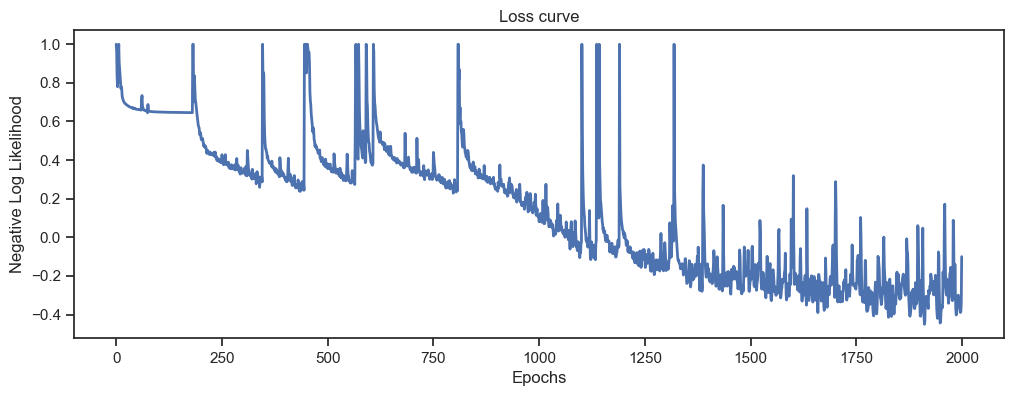

In [ ]:
#%%

### Serialse the model
eqx.tree_serialise_leaves("model.eqx", model)

## Plot the loss curve
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(np.clip(losses, None, 1))
ax.set_xlabel("Epochs")
ax.set_ylabel("Negative Log Likelihood")
# ax.set_yscale("log")
# ax.set_ylim(0, 10)
ax.set_title("Loss curve")

fig.savefig("loss_curve.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Yt_hat shape:  [[[0.13822283 0.10956214 0.13539079]
  [0.14106621 0.10818957 0.1344377 ]
  [0.13785355 0.10166665 0.13170013]
  ...
  [0.13919897 0.10672455 0.13720718]
  [0.15808338 0.12152383 0.1530231 ]
  [0.16269623 0.13000165 0.16058661]]

 [[0.1432593  0.11340856 0.1407069 ]
  [0.14956611 0.11498242 0.14267795]
  [0.1532285  0.11593498 0.14634854]
  ...
  [0.14156581 0.10618981 0.13896939]
  [0.14993843 0.10689921 0.14248262]
  [0.16203626 0.12721273 0.15377259]]

 [[0.14259589 0.10792859 0.1396715 ]
  [0.13931455 0.10665286 0.13656735]
  [0.17955333 0.13173456 0.17083973]
  ...
  [0.10799996 0.08057202 0.10494515]
  [0.12403255 0.08986335 0.12060779]
  [0.15876065 0.1292444  0.15245664]]

 ...

 [[0.12643626 0.0944631  0.10049833]
  [0.13126516 0.09852532 0.10425308]
  [0.10620431 0.08260741 0.08371405]
  ...
  [0.10004094 0.07449287 0.07678396]
  [0.10416024 0.0779924  0.07881863]
  [0.1242985  0.09315246 0.09330273]]

 [[0.11724088 0.09720913 0.10045972]
  [0.12636198 0.097868

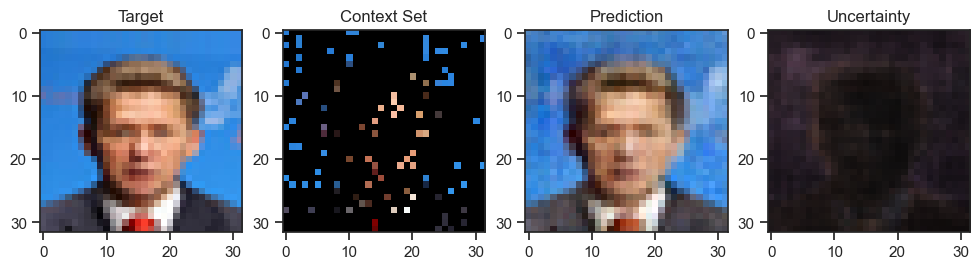

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Yt_hat shape:  [[[0.07470608 0.06814485 0.07456905]
  [0.08459183 0.07846715 0.08334482]
  [0.08076691 0.07378452 0.07884029]
  ...
  [0.17750925 0.13915555 0.13426302]
  [0.13299143 0.10897237 0.10576449]
  [0.06829172 0.06259916 0.06716951]]

 [[0.0808342  0.07402885 0.08232684]
  [0.07741328 0.07068355 0.07605617]
  [0.07861611 0.06903363 0.07879088]
  ...
  [0.16170464 0.12961043 0.12667304]
  [0.09568347 0.07925941 0.08315955]
  [0.07269726 0.06670124 0.07145317]]

 [[0.07394355 0.06834327 0.0738776 ]
  [0.07020314 0.0645253  0.07145957]
  [0.08422263 0.07647933 0.08379143]
  ...
  [0.16573682 0.13122217 0.12917608]
  [0.11935924 0.10811986 0.1142276 ]
  [0.09368721 0.08401752 0.09682824]]

 ...

 [[0.09600887 0.07475612 0.07424101]
  [0.10089023 0.07801019 0.07892866]
  [0.07807779 0.05917697 0.05325031]
  ...
  [0.08037028 0.06046014 0.06015222]
  [0.06029041 0.05070458 0.05132456]
  [0.05440586 0.04750071 0.047759  ]]

 [[0.09100987 0.07966477 0.073765  ]
  [0.08796977 0.068737

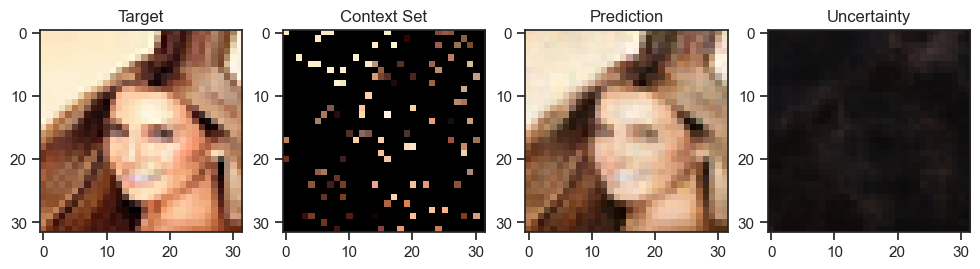

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(iter(train_dataloader))
tgt_batch = next(iter(all_shots_train_dataloader))
Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


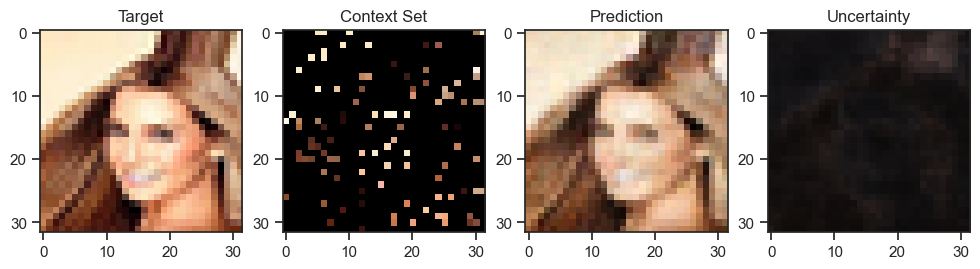

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(iter(train_dataloader))
tgt_batch = next(iter(all_shots_train_dataloader))

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


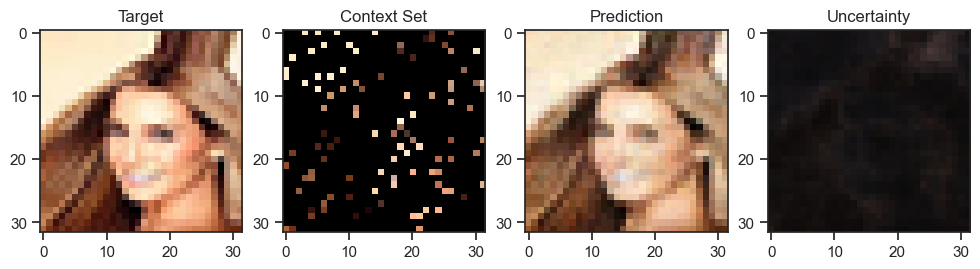

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(iter(train_dataloader))
tgt_batch = next(iter(all_shots_train_dataloader))

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


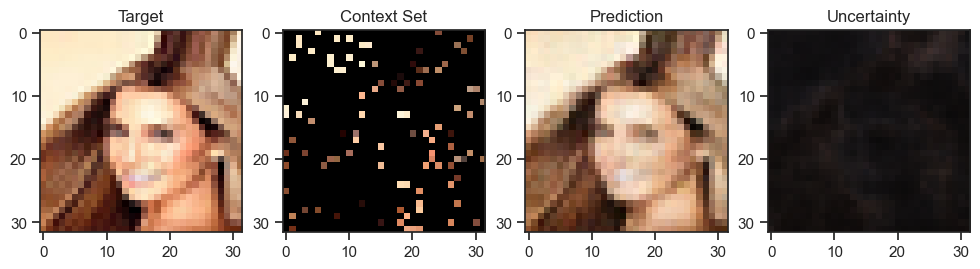

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(iter(train_dataloader))
tgt_batch = next(iter(all_shots_train_dataloader))

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


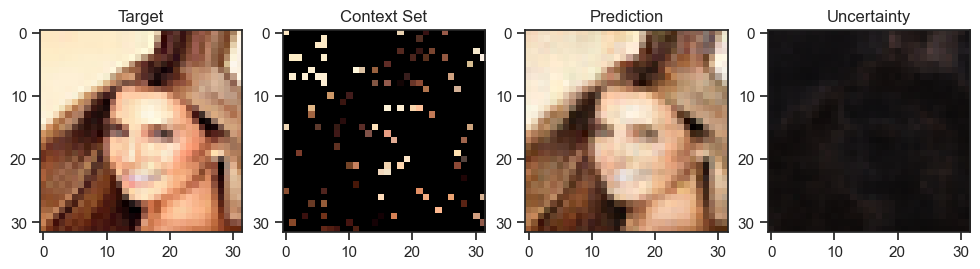

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(iter(train_dataloader))
tgt_batch = next(iter(all_shots_train_dataloader))

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


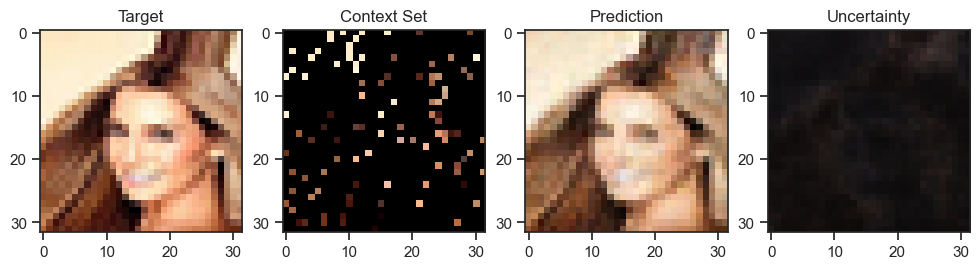

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(iter(train_dataloader))
tgt_batch = next(iter(all_shots_train_dataloader))

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


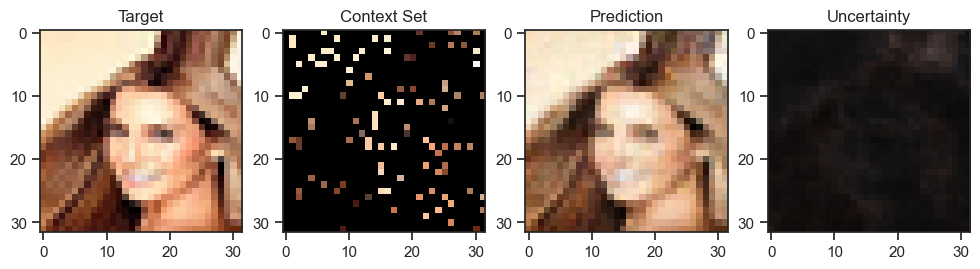

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(iter(train_dataloader))
tgt_batch = next(iter(all_shots_train_dataloader))

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


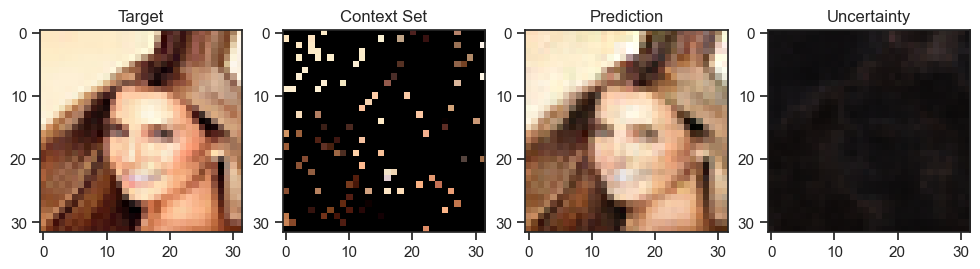

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(iter(train_dataloader))
tgt_batch = next(iter(all_shots_train_dataloader))

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


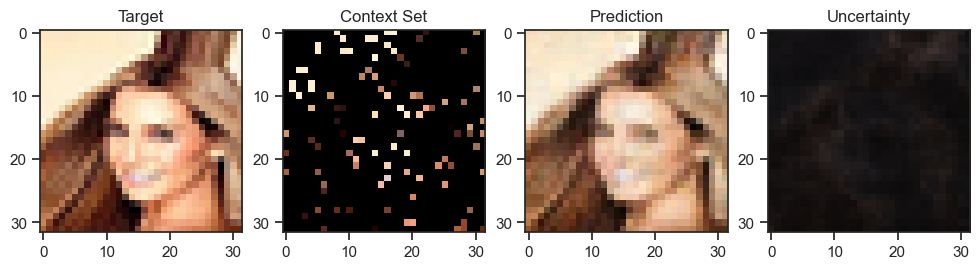

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(iter(train_dataloader))
tgt_batch = next(iter(all_shots_train_dataloader))

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


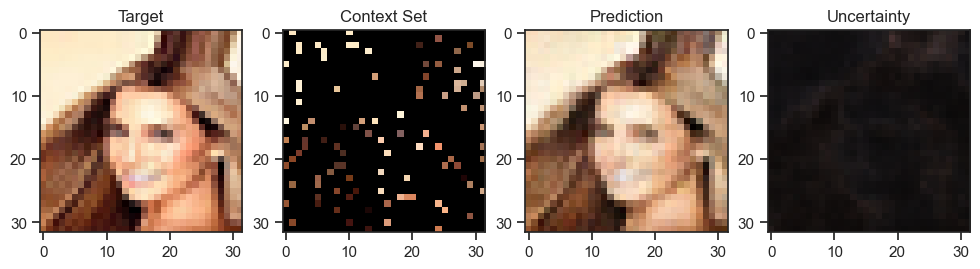

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(iter(train_dataloader))
tgt_batch = next(iter(all_shots_train_dataloader))

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

In [ ]:
#%% 

gen_train_dataloader = iter(train_dataloader)
gen_all_shots_train_dataloader = iter(all_shots_train_dataloader)

# dat = next(iter(all_shots_train_dataloader))
# dat_few_shots = next(iter(train_dataloader))

# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# img = make_image(dat[0][0], dat[1][0], img_size=(*resolution, 3))
# axs[0].imshow(img)

# img_fs = make_image(dat_few_shots[0][0], dat_few_shots[1][0], img_size=(*resolution, 3))
# axs[1].imshow(img_fs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


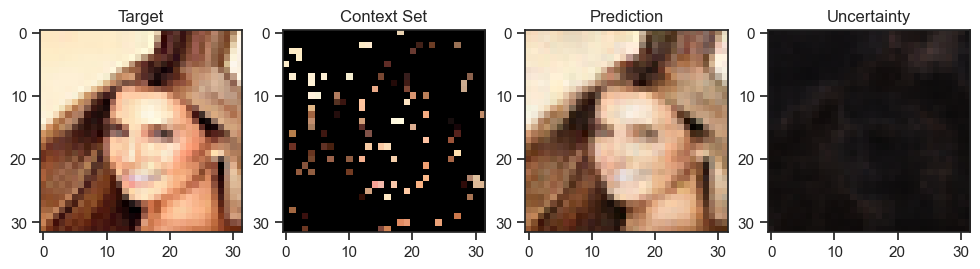

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


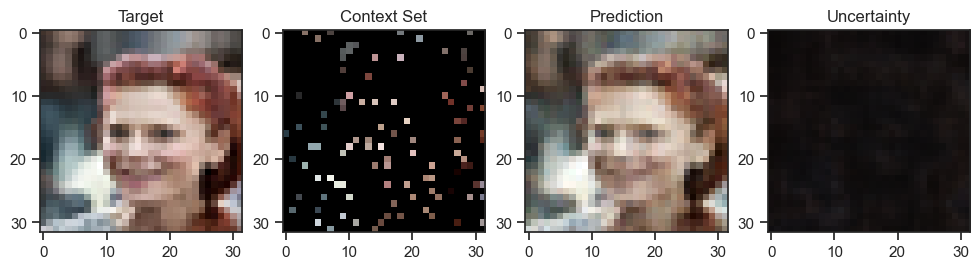

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


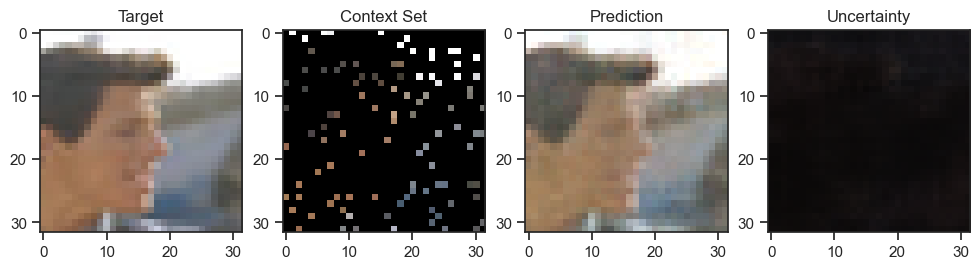

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


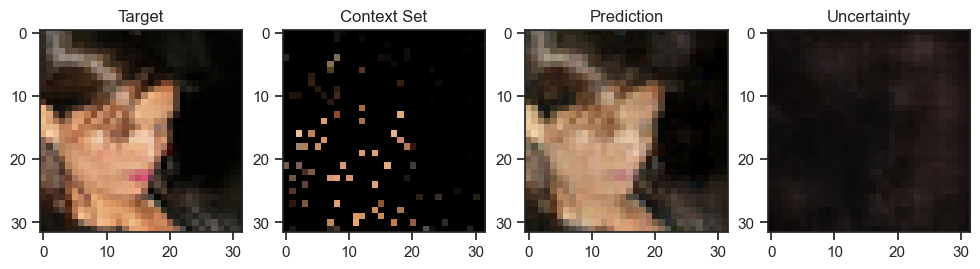

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

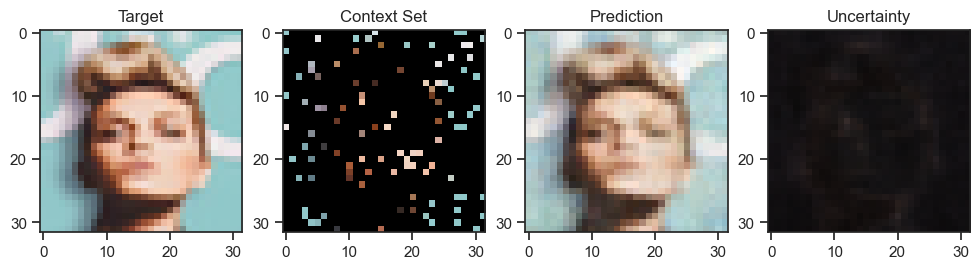

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


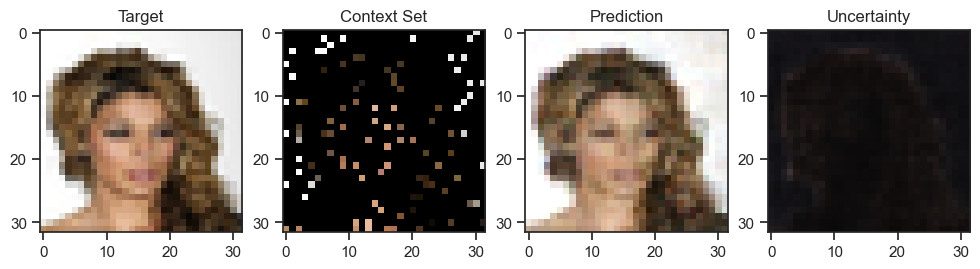

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


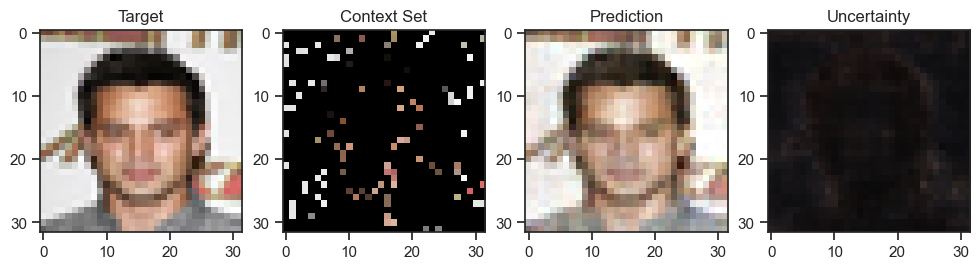

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


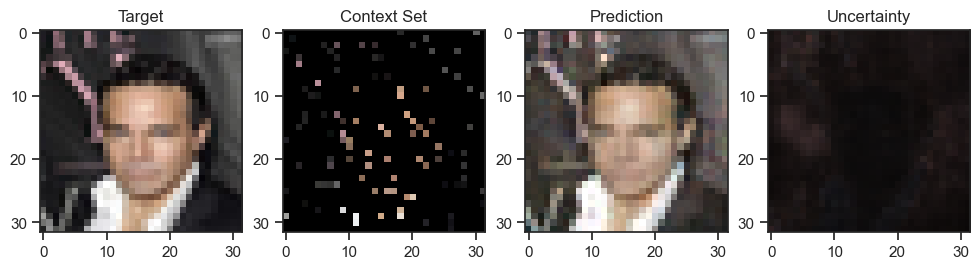

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


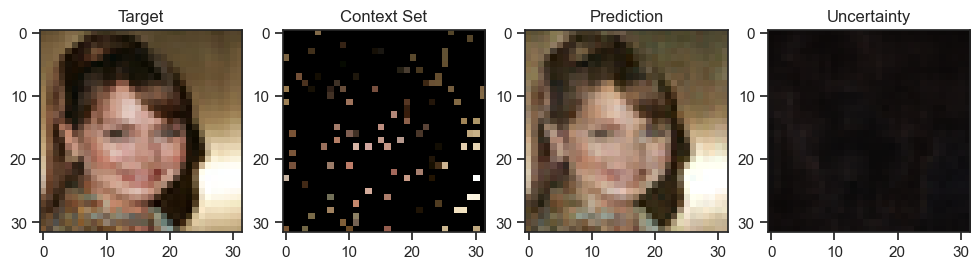

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


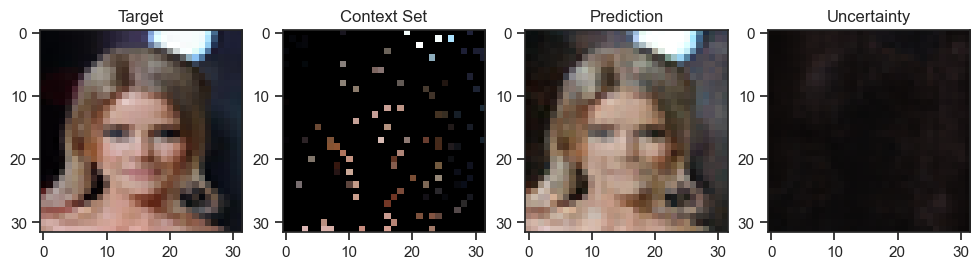

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


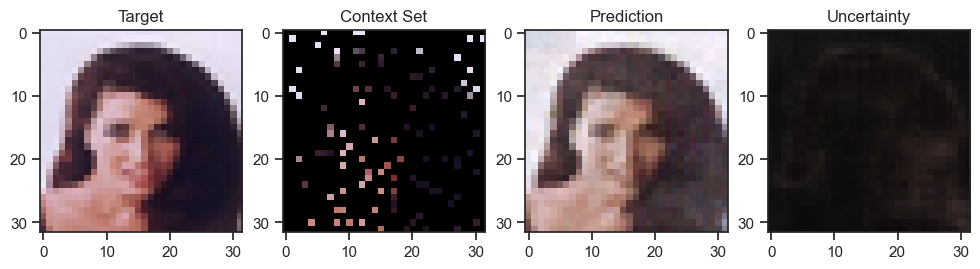

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


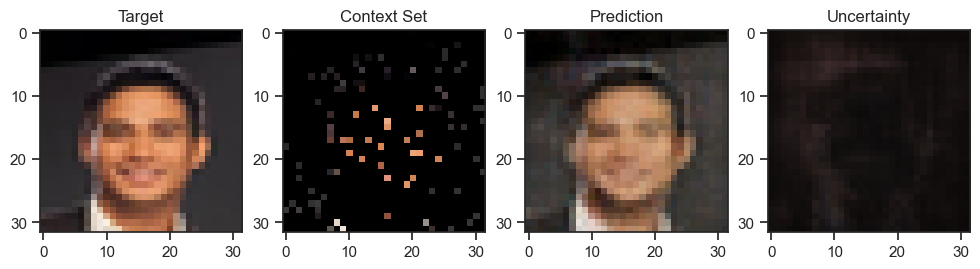

In [ ]:
#%%

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# Visualize an examploe prediction from the latest batch
ctx_batch = next(gen_train_dataloader)
tgt_batch = next(gen_all_shots_train_dataloader)

Xc, Yc = ctx_batch
Xt, Yt = tgt_batch
mus, sigmas = model(Xc, Yc)
# mus, sigmas = jax.tree_map(lambda x: x.reshape((-1, 1024, C)), (mus, sigmas))

test_key = jax.random.PRNGKey(time.time_ns())
# Yt_hat = jax.random.normal(test_key, mus.shape) * sigmas + mus
Yt_hat = mus

plt_idx = jax.random.randint(test_key, (1,), 0, envs_batch_size_all)[0]
# print("Yt_hat shape: ", sigmas[plt_idx])

img_true = make_image(Xt[plt_idx], Yt[plt_idx], img_size=(*resolution, 3))
ax1.imshow(img_true)
ax1.set_title(f"Target")

img_fw = make_image(Xc[plt_idx], Yc[plt_idx], img_size=(*resolution, 3))
ax2.imshow(img_fw)
ax2.set_title(f"Context Set")

# img_pred = make_image(Xt[plt_idx], Yt_hat[plt_idx], img_size=(*resolution, 3))
img_pred = mus[plt_idx]
ax3.imshow(img_pred)
ax3.set_title(f"Prediction")

# img_std = make_image(Xt[plt_idx], sigmas[plt_idx], img_size=(*resolution, 3))
img_std = sigmas[plt_idx]
## rescale to 0-1
# img_std = (img_std - img_std.min()) / (img_std.max() - img_std.min())
ax4.imshow(img_std)
ax4.set_title(f"Uncertainty")

fig.savefig("predictions.png")